In [327]:
import os
import glob
import math
from tqdm import tqdm_notebook as tqdm

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

In [276]:
car_max = 9
cmap='Reds'

In [277]:
# ファイルパスのリストを作る
def make_datapath_list(name='Columbus_CSUAV_AFRL/*',):
    rootpath = '../data/'
    target_path = os.path.join(rootpath+name+'/*.png')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

test_scene = make_datapath_list(name='testing_scenes')

../data/testing_scenes/*.png


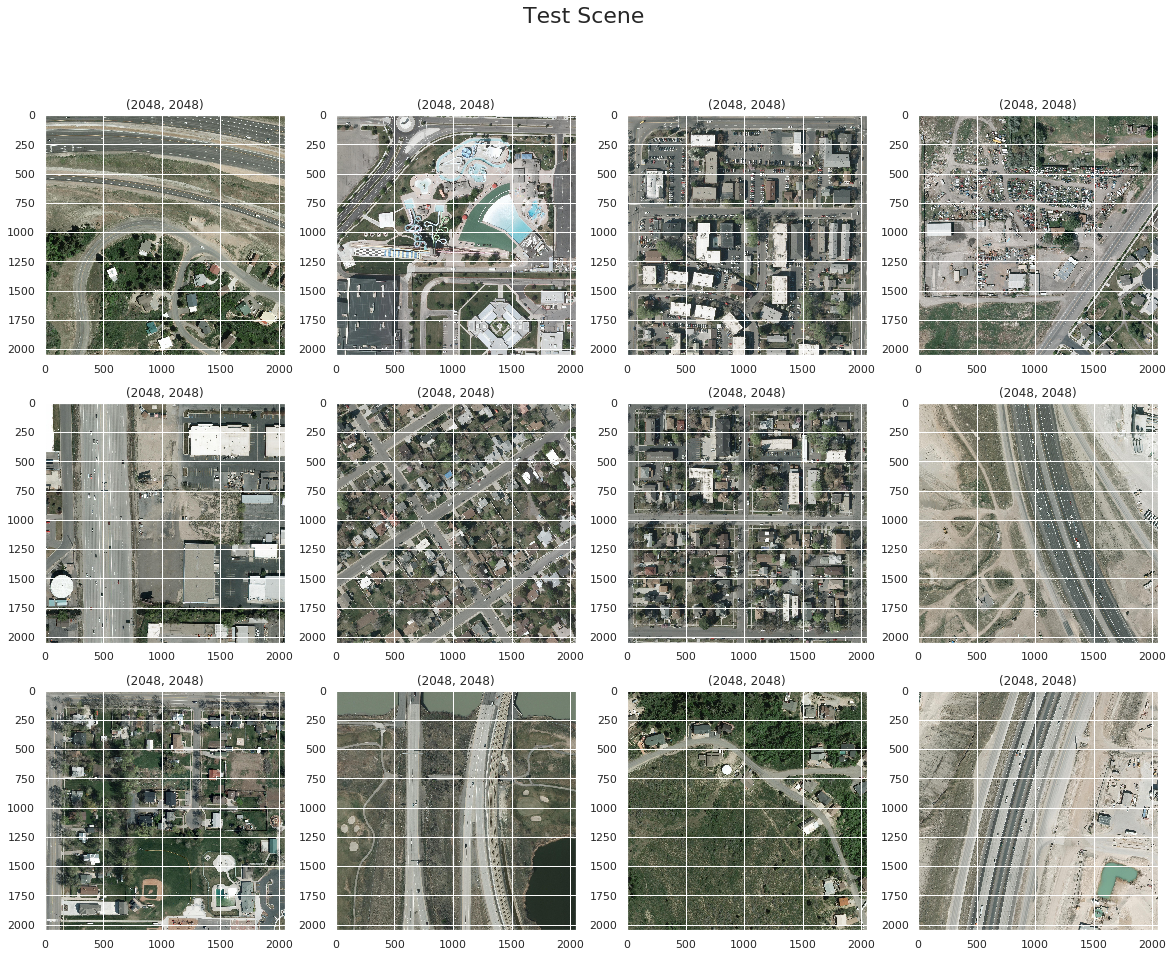

In [278]:
plt.figure(figsize=(20,15))
plt.suptitle('Test Scene', fontsize=22)
for i,file_path in enumerate(test_scene[:12]):
    plt.subplot(3,4,i+1)
    img = Image.open(file_path)
    plt.imshow(img)
    #plt.axis('off')
    plt.title(img.size)
plt.show()

### パッチわけする

In [466]:
def add_margin(img, top, right, bottom, left, color):
    '''
    上下に余白をつくる
    '''
    width, height = img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(img.mode, (new_width, new_height), color)
    result.paste(img, (left, top))
    return result

def crop_img(img, crop, margin):
    '''
    画像を与えられたサイズのパッチにわける
    x_cnt*y_cnt = 全画像枚数
    input
    - img : 元画像
    - crop_size : パッチのサイズ
    - margin : 画像周りの余白サイズ
    output 
    - imgs : パッチわけされた画像のリスト
    - x_cnt : 列数
    - y_cnt :行数
    '''
    crop_size = crop+margin*2
    width = img.size[0]
    height = img.size[1]
    imgs = []
    
    x_cnt = math.ceil(width/crop_size)
    y_cnt = math.ceil(height/crop_size)
    for y in range(0, height, crop_size):
        for x in range(0, width, crop_size):
            imgCrop = img.crop((x, y, x+crop_size, y+crop_size))
            imgCrop_margin = add_margin(imgCrop, top=margin, right=margin, bottom=margin, left=margin, color=(0, 0, 0))
            imgs.append(imgCrop_margin) 
    return imgs, x_cnt, y_cnt

In [468]:
# 元画像を選択
img_path = test_scene[6]
img_ori = Image.open(img_path)
img_ori = img_ori.convert('RGB')
# パッチサイズの定義
crop=256
margin=0
# パッチされた画像を格納
imgs, x_cnt, y_cnt = crop_img(img_ori, crop, margin)
print('画像数',len(imgs))

画像数 64


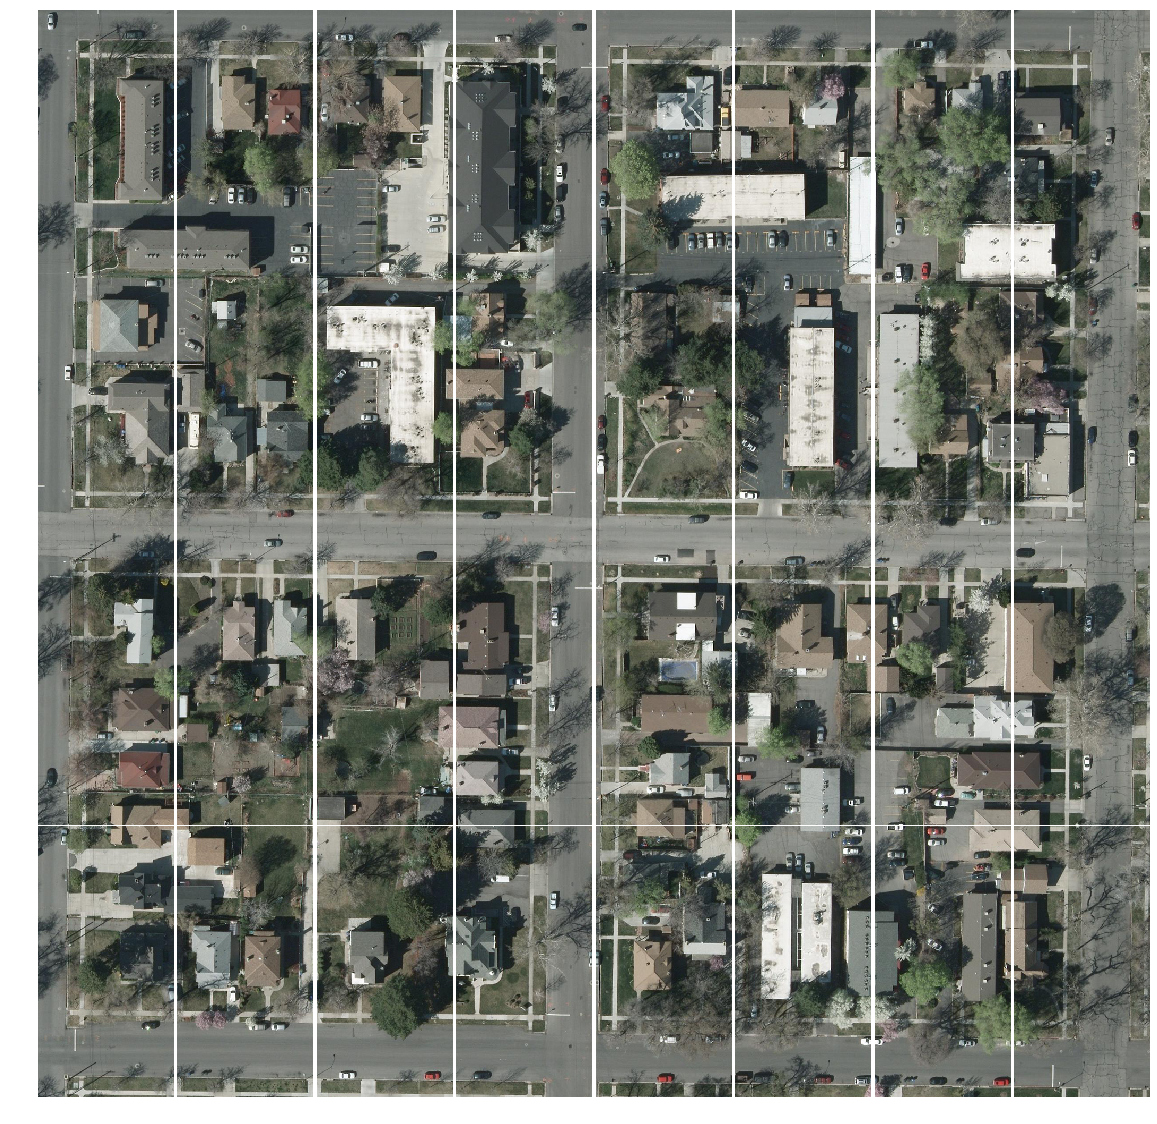

In [469]:
## 描画して確認
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0, wspace=0)
for i, img in enumerate(imgs):
    #img = img.resize((256, 256))
    plt.subplot(y_cnt,x_cnt,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### 推論

In [470]:
class ImageTransform():
    def __init__(self,size=256, p=0.5,degrees=90):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(size),
                transforms.RandomHorizontalFlip(p=p),
                transforms.RandomVerticalFlip(p=p),
                #transforms.RandomAffine(degrees=degrees),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [471]:
# モデルのロード
net = models.resnet50()

# 最後の層を付け替える
net.fc = nn.Linear(in_features=2048, out_features=10)

# #PyTorchのネットワークパラメータのロード
load_path = './weights/cowc_resnet_50.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [472]:
# 予測結果を元画像に合成する関数たち
def get_color_map(sns_palette):
    '''
    カラーマップ取得
    '''
    color_map = np.empty(shape=[0,3], dtype=np.uint8)
    
    for color in sns_palette:
        r = int(color[0]*255)
        g = int(color[1]*255)
        b = int(color[2]*255)
        rgb_byte = np.array([[r, g, b]], dtype=np.uint8)
        color_map = np.append(color_map, rgb_byte, axis=0)
        
    return color_map

def overlay_heatmap(img_ori, cars_cnt,car_max=9, crop_size=256, margin=0, cmap='Reds'):
    '''
    予測結果のヒートマップを元画像に合成
    input
    - img_ori : 元画像
    - cars_cnt : 予測結果リスト
    - car_max : 最大予測値
    output
    元画像とヒートマップを合成した画像
    '''
    # 元画像のサイズ取得
    size = img_ori.size

    #取得したサイズと同じ空のイメージを新規に作成
    im2 = Image.new('RGB',size)

    # 画像をnumpy型に
    im2 = np.array(im2, np.float)

    # カラーマップの設定
    cmap = 'Reds'
    sns_palette = sns.color_palette(cmap, n_colors=car_max+1)
    color_map = get_color_map(sns_palette)
    i = 0
    # ヒートマップの作成
    for y in range(0, height, crop_size+margin*2):
            for x in range(0, width, crop_size+margin*2):
                im2[x:x+crop_size, y:y+crop_size] = color_map[cars_cnt[i]]
                i += 1

    im2 = Image.fromarray(np.uint8(im2))
    
    # 画像合成
    assert img_ori.size==im2.size, 'size is different'
    mask = Image.new("L", img_ori.size, 128) 
    composi_img = Image.composite(img_ori, im2, mask)
    
    return composi_img 
    
def plot_counts_on_heatmap(heatmap_pverlayed,):
    pass


In [473]:
# softmax関数
softmax = nn.Softmax(dim=1)

def predict(net, img):
    '''
    予測結果を返す関数
    input
    - net : モデル
    - img : 予測する画像
    output
    - 予測結果 ex) 3
    '''
    img = img.convert('RGB')
    transform = ImageTransform()
    img_transformed = transform(img, phase='val')
    x = img_transformed.unsqueeze(0)
    pre_cnt = net(x)
    pre_cnt = torch.argmax(softmax(pre_cnt),dim=1)
    return pre_cnt.cpu().numpy()[0]

In [474]:
# 予測結果格納
cars_cnt = []
for img in tqdm(imgs):
    pre_cnt = predict(net, img)
    cars_cnt.append(pre_cnt)

In [475]:
# 合成画像取得
composi_img = overlay_heatmap(img_ori, cars_cnt)

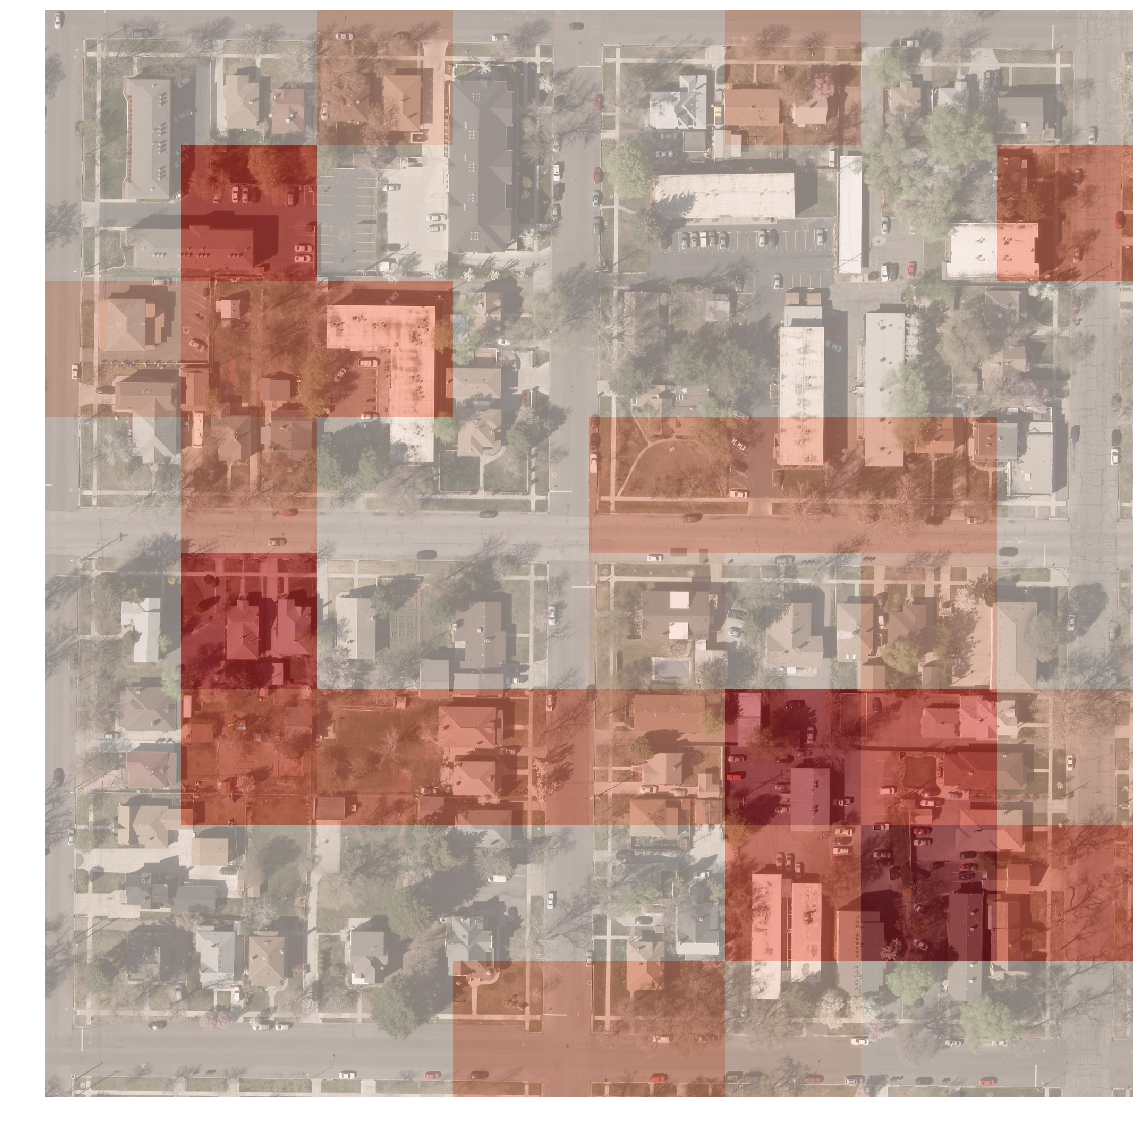

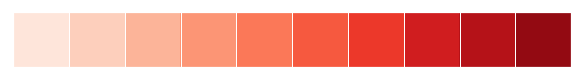

In [476]:
# 合成結果表示
plt.figure(figsize=(20,20))
plt.imshow(composi_img)
plt.axis('off')
sns.palplot(sns.color_palette(cmap, n_colors=car_max+1))

In [479]:
cars_cnt[52]

2

../data/Potsdam_ISPRS/*/*.png


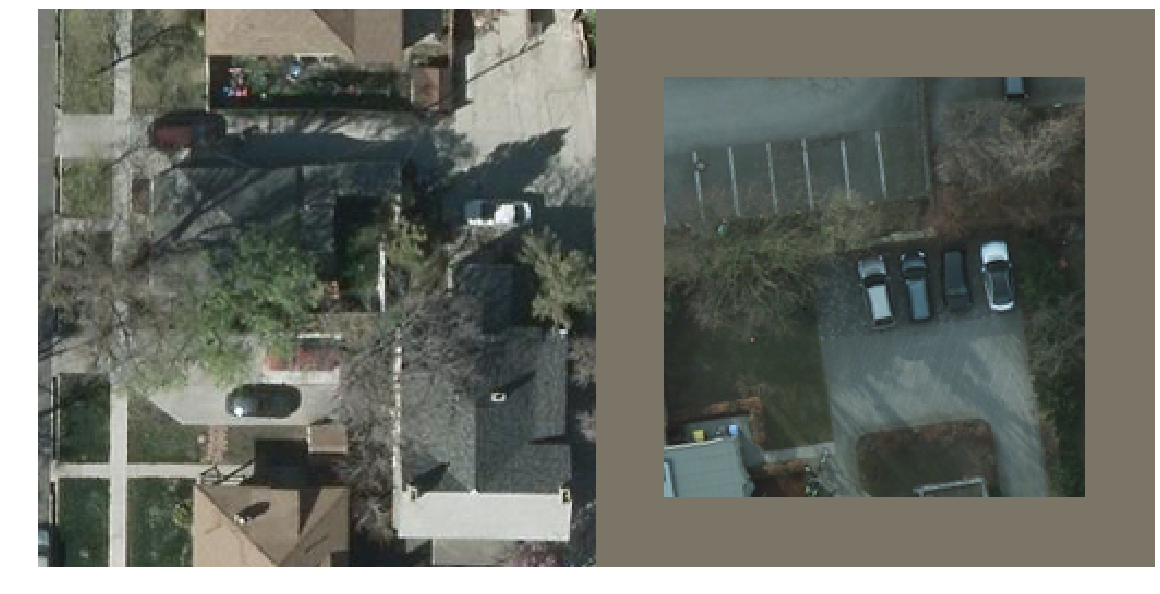

In [478]:
size=256
img = imgs[52]
img = img.resize((size, size))

Potsdam = make_datapath_list(name='Potsdam_ISPRS/*')
img_p = Potsdam[4]
img_p = Image.open(img_p)
img_p = img_p.resize((size, size))
assert img.size==img_p.size,'size is different'
comp_imgs = [img, img_p]


## 描画して確認
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0, wspace=0)
for i, img in enumerate(comp_imgs):
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

パッチわけのサイズが小さいと(256)にリサイズした時に解像度がすごく悪くなるので予測結果の精度が良くない

### 評価

In [428]:
df = pd.read_csv('./log/cowc_log.csv')
print(len(df))
df.head()

68


Unnamed: 0  epoch  finish_time  train_acc  train_loss   val_acc  val_loss
0           0      1   329.060441   0.000000         inf  0.082244  2.402844
1           1      2  2484.693973   0.658875    0.956777  0.727418  0.712233
2           2      3  2481.332959   0.745566    0.667441  0.766871  0.596499
3           3      4  2490.501877   0.779854    0.570555  0.790996  0.530985
4           4      5  2489.411713   0.801948    0.513122  0.805670  0.496142

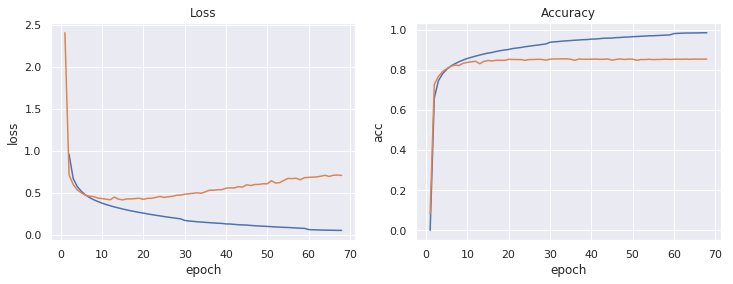

In [477]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

axL.plot(df.epoch, df.train_loss, label='train')
axL.plot(df.epoch, df.val_loss, label='val')
axL.set_title('Loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.grid(True)

axR.plot(df.epoch, df.train_acc, label='train')
axR.plot(df.epoch, df.val_acc, label='val')
axR.set_title('Accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('acc')
axR.grid(True)

fig.show()

In [ ]:
# #PyTorchのネットワークパラメータのロード
load_path = './weights/cowc_resnet_10.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

## CPU上で重みをロードする場合
#load_weights = torch.load(load_path, map_location={'cuda:0':'cpu'})
#net.load_state_dict(load_weights)

In [ ]:
net.eval()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス',device)
# ネットワークをGPUへ
net.to(device)

for i, (inputs, labels) in enumerate(tqdm(dataloaders_dict['val'])):

    # GPUにデータを送る
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    ## 予測
    
    pred = net(inputs)
    ## softmaxにかけた後、確率最大を取り出す
    softmax = torch.nn.Softmax(dim=1)
    pred = torch.argmax(softmax(pred),dim=1)
    
    if i ==0:
        predict = pred
        true = labels
    else:
        predict = torch.cat((predict, pred),dim=0)
        true = torch.cat((true,labels),dim=0)

In [ ]:
cm = confusion_matrix(predict.cpu(), true.cpu())
print(accuracy_score(predict.cpu(),true.cpu()))
print(cm)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True)